In [2]:
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

import numpy as np
from astropy.table import Table, join
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.spatial import cKDTree
import os

In [3]:
initial_values = Table.read('../spectrum_analysis/galah_dr4_initial_parameters_220714_lite.fits')

In [4]:
grids = Table.read('galah_dr4_model_trainingset_gridpoints.fits')

In [5]:
grids['model_name'] = np.array([str(int(grid['teff_subgrid']))+'_'+str("{:.2f}".format(grid['logg_subgrid']))+'_'+str("{:.2f}".format(grid['fe_h_subgrid'])) for grid in grids])

In [6]:
grid_index_tree = cKDTree(np.c_[grids['teff_subgrid']/1000.,grids['logg_subgrid'],grids['fe_h_subgrid']])

In [7]:
initial_values['grid_index'] = np.array([grid_index_tree.query([tgf[0]/1000.,tgf[1],tgf[2]]) for tgf in np.array([initial_values['teff'],initial_values['logg'],initial_values['fe_h']]).T])[:,1]

In [8]:
indices = initial_values['grid_index']
priority = Table()
d,c = np.unique(indices, return_counts=True)
priority['index_subgrid'] = np.array(d,dtype=int)
priority['counts_dr4_init'] = np.array(c,dtype=int)
priority = join(priority, grids, keys='index_subgrid')
priority.sort(keys='counts_dr4_init',reverse=True)

In [9]:
def test_grid_index_computations(test_grid_index = 1931, print_all_points=False,):
    if print_all_points:
        print('Printing grid points not yet computed for '+str(grids['model_name'][test_grid_index])+':')

    # Find upper and lower Teff points
    test_grid_teff = int(grids['teff_subgrid'][test_grid_index])
    if test_grid_teff <= 4000:
        test_grid_teff_lower = test_grid_teff - 100
    else:
        test_grid_teff_lower = test_grid_teff - 250
    if test_grid_teff <= 3900:
        test_grid_teff_higher = test_grid_teff + 100
    else:
        test_grid_teff_higher = test_grid_teff + 250

    # Find upper and lower logg points
    test_grid_logg = grids['logg_subgrid'][test_grid_index]
    test_grid_logg_lower = test_grid_logg - 0.5
    test_grid_logg_higher = test_grid_logg + 0.5

    # Find upper and lower fe_h points
    test_grid_fe_h = grids['fe_h_subgrid'][test_grid_index]
    if test_grid_fe_h <= -0.75:
        test_grid_fe_h_lower = test_grid_fe_h - 0.5
    else:
        test_grid_fe_h_lower = test_grid_fe_h - 0.25
    if test_grid_fe_h <= -1.5:
        test_grid_fe_h_higher = test_grid_fe_h + 0.5
    else:
        test_grid_fe_h_higher = test_grid_fe_h + 0.25

    for teff in [test_grid_teff_lower,test_grid_teff,test_grid_teff_higher]:
        for logg in [test_grid_logg_lower,test_grid_logg,test_grid_logg_higher]:
            for fe_h in [test_grid_fe_h_lower,test_grid_fe_h,test_grid_fe_h_higher]:
                t = grids['index_subgrid'][grids['model_name'] == str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h)]
                if len(t) > 0:
                    if t[0] not in grids_done:
                        if t[0] not in grids_started:
                            if print_all_points:
                                print(t[0],str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h))
                            else:
                                print(str(t[0])+',')
                        else:
                            if print_all_points:
                                print(t[0],str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h), 'already started')
                    else:
                        if print_all_points:
                            print(t[0],str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h), 'already done')
                else:
                    if print_all_points:
                        print('Not in GRID :', str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h))
                    

In [10]:
def test_grid_index_ready_for_training(test_grid_index = 1931, print_all_points=False,):
    if print_all_points:
        print('Printing grid points not yet computed for '+str(grids['model_name'][test_grid_index])+':')

    # Find upper and lower Teff points
    test_grid_teff = int(grids['teff_subgrid'][test_grid_index])
    if test_grid_teff <= 4000:
        test_grid_teff_lower = test_grid_teff - 100
    else:
        test_grid_teff_lower = test_grid_teff - 250
    if test_grid_teff <= 3900:
        test_grid_teff_higher = test_grid_teff + 100
    else:
        test_grid_teff_higher = test_grid_teff + 250

    # Find upper and lower logg points
    test_grid_logg = grids['logg_subgrid'][test_grid_index]
    test_grid_logg_lower = test_grid_logg - 0.5
    test_grid_logg_higher = test_grid_logg + 0.5

    # Find upper and lower fe_h points
    test_grid_fe_h = grids['fe_h_subgrid'][test_grid_index]
    if test_grid_fe_h <= -0.75:
        test_grid_fe_h_lower = test_grid_fe_h - 0.5
    else:
        test_grid_fe_h_lower = test_grid_fe_h - 0.25
    if test_grid_fe_h <= -1.5:
        test_grid_fe_h_higher = test_grid_fe_h + 0.5
    else:
        test_grid_fe_h_higher = test_grid_fe_h + 0.25

    for teff in [test_grid_teff_lower,test_grid_teff,test_grid_teff_higher]:
        for logg in [test_grid_logg_lower,test_grid_logg,test_grid_logg_higher]:
            for fe_h in [test_grid_fe_h_lower,test_grid_fe_h,test_grid_fe_h_higher]:
                t = grids['index_subgrid'][grids['model_name'] == str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h)]
                if len(t) > 0:
                    if t[0] not in grids_converted_to_nn_input:
                        print(t[0],str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h),' not ready')
                    else:
                        print(t[0],str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h),' done')
                else:
                    if print_all_points:
                        print('Not in GRID :', str(int(teff))+'_'+"{:.2f}".format(logg)+'_'+"{:.2f}".format(fe_h))
                    

In [30]:
grids_started = [
478, # for analysis of 131216001101084
1110,
1111,
1121,
1122,
1123,
1133,
1134,
1135,
1232,
1233,
# 1246,
# 1258,
# 1270,
1340,
1341,
1342,
# 1355,
# 1367,
# 1379,
1446,
1447,
1448,
# 1461,
# 1473,
# 1485,
1552,
1609,
1685,
]

In [31]:
grids_done = [
    1109,
    1231,
    1242,1243,1244,1245,
    1254,1255,1256,1257,
    1266,1267,1268,1269,
    1351,1352,1353,1354,
    1363,1364,1365,1366,
    1375,1376,1377,1378,
    1387,1388,1389,1390,
    1457,1458,1459,
    1460,
    1469,
    1470,1471,1472,
    1481,1482,1483,1484,
    1493,1494,1495,1496,
    1506,1507,1508,
    1560,1561,1562,1563,
    1572,1573,1574,1575,
    1584,1585,1586,1587,
    1596,1597,1598,1599,
    1610,1611,
    1672,1673,1674,
    1684,
    1686,
    1695,1696,1697,1698,
    1707,1708,1709,1710,
    1719,1720,1721,
    1724,1725,1726,1727,1728,
    1736,1737,1738,1739,1740,   
    1748,1749,
    1750,1751,1752,
    1790,1791,1792,
    1802,1803,1804,
    1814,1815,1816,
    1819,
    1820,1821,1822,1823,
    1831,1832,1833,1834,1835,
    1843,1844,1845,1846,1847,
    1876,1877,1878,
    1888,1889,
    1890,
    1900,1901,1902,
    1905,1906,1907,1908,1909,
    1917,1918,1919,
    1920,1921,
    1929,
    1930,1931,1932,1933,
    1988,1989,
    1990,1991,1992,
    2000,2001,2002,2003,2004,
    2012,2013,2014,2015,2016,
    2065,2066,2067,2068,2069,
    2077,2078,2079,
    2080,2081,
    2089,
    2090,2091,2092,2093,
]
print(len(grids_done),len(grids_done) * 280)

176 49280


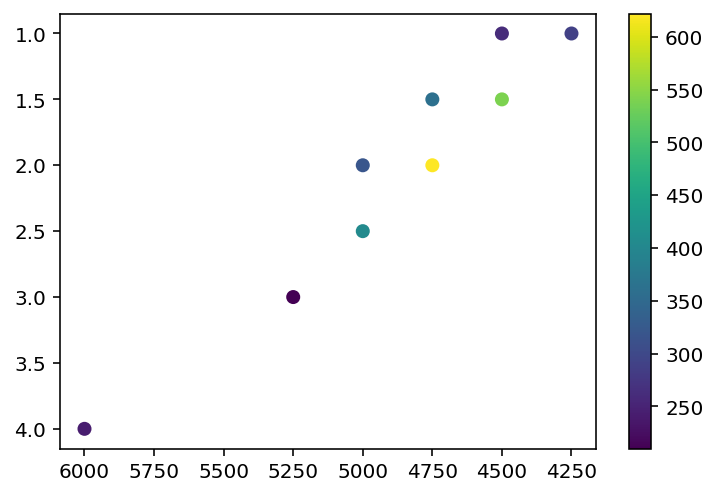

[1483, 1365, 1598, 1471, 1586, 1244, 1353, 1997, 1709]


index_subgrid,counts_dr4_init,teff_subgrid,teff_low_subgrid,teff_high_subgrid,logg_subgrid,logg_low_subgrid,logg_high_subgrid,fe_h_subgrid,fe_h_low_subgrid,fe_h_high_subgrid,random_seed_subgrid,model_name
int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,str15
1483,622,4750.0,4500.0,5000.0,2.0,1.5,2.5,-1.5,-2.0,-1.0,4620,4750_2.00_-1.50
1365,541,4500.0,4250.0,4750.0,1.5,1.0,2.0,-1.5,-2.0,-1.0,4365,4500_1.50_-1.50
1598,406,5000.0,4750.0,5250.0,2.5,2.0,3.0,-1.5,-2.0,-1.0,4875,5000_2.50_-1.50
1471,360,4750.0,4500.0,5000.0,1.5,1.0,2.0,-1.5,-2.0,-1.0,4615,4750_1.50_-1.50
1586,321,5000.0,4750.0,5250.0,2.0,1.5,2.5,-1.5,-2.0,-1.0,4870,5000_2.00_-1.50
1244,290,4250.0,4000.0,4500.0,1.0,0.5,1.5,-1.5,-2.0,-1.0,4110,4250_1.00_-1.50
1353,260,4500.0,4250.0,4750.0,1.0,0.5,1.5,-1.5,-2.0,-1.0,4360,4500_1.00_-1.50
1997,243,6000.0,5750.0,6250.0,4.0,3.5,4.5,-1.5,-2.0,-1.0,5890,6000_4.00_-1.50
1709,210,5250.0,5000.0,5500.0,3.0,2.5,3.5,-1.5,-2.0,-1.0,5130,5250_3.00_-1.50


In [32]:
selection = (priority['fe_h_subgrid'] <= -2) & (priority['counts_dr4_init'] > 200)
selection = (priority['fe_h_subgrid'] > -2) & (priority['fe_h_subgrid'] <= -1.5) & (priority['counts_dr4_init'] > 200) & (priority['teff_subgrid'] <= 6000)
# selection = (priority['fe_h_subgrid'] <= -0.75) & (priority['counts_dr4_init'] > 2800)


f, ax = plt.subplots()
s = ax.scatter(
    priority['teff_subgrid'][selection],
    priority['logg_subgrid'][selection],
    c = priority['counts_dr4_init'][selection],
)
plt.colorbar(s, ax=ax)
ax.set_xlim(ax.get_xlim()[::-1])
ax.set_ylim(ax.get_ylim()[::-1])
plt.show()
plt.close()

print(list(priority['index_subgrid'][selection]))

priority[selection]

In [33]:
# ALREADY DONE
selection = [
    1244,
    1341,
    1353,
    1364,1365,1366,
    1458,
    1470,1471,
    1482,1483,
    1586,
    1598,
#     1709, # <= new
    1803,
    1832,1833,1834,
    1844,1845,1846,
    1918,1919,1920,
    1930,1931,1932,
#     1997, # <= new
    2001,2002,2003,
    2013,2014,2015,
]
# selection = []

for t in selection:
    test_grid_index_computations(t)

1246,
1258,
1270,
1355,
1367,
1379,
1461,
1473,
1485,


In [58]:
grids_converted_to_nn_input = [
    1109,
    1231,
    1242,1243,1244,1245,
    1254,1255,1256,1257,
    1266,1267,1268,1269,
    1351,1352,1353,1354,
    1363,1364,1365,1366,
    1375,1376,1377,1378,
    1387,1388,1389,
    1390,
    1457,1458,1459,
    1460,
    1469,
    1470,1471,1472,
    1481,1482,1483,1484,
    1493,1494,1495,1496,
    1506,1507,1508,
    1560,1561,1562,1563,
    1572,1573,1574,1575,
    1584,1585,1586,1587,
    1596,1597,1598,1599,
    1610,1611,
    1695,1696,1697,
    1672,
    1684,
    1686,
    1698,
    1707,1708,1709,
    1710,
    1719,1720,1721,
    1724,1725,1726,1727,1728,
    1736,1737,1738,1739,1740,
    1748,1749,
    1750,1751,1752,
    1790,1791,1792,
    1802,1803,1804,
    1814,1815,1816,
    1819,1820,1821,1822,1823,
    1831,1832,1833,1834,1835,
    1843,1844,1845,1846,1847,
    1876,1877,1878,
    1888,1889,
    1890,
    1900,1901,1902,
    1905,1906,1907,1908,1909,
    1917,1918,1919,
    1920,1921,
    1929,1930,1931,1932,1933,
    1988,1989,1990,1991,1992,
    2000,2001,2002,2003,2004,
    2012,2013,2014,2015,2016,
    2065,2066,2067,2068,2069,
    2077,2078,2079,
    2080,2081,
    2089,
    2090,2091,2092,2093,
]
print(len(grids_converted_to_nn_input))

174


In [82]:
for s in [1586]: # 1341,1353,1366,1458,1586
    test_grid_index_ready_for_training(test_grid_index = s)
    # ready:
    # 1364,1365,
    # 1470,1471,
    # 1482,1483,
    # 1832,1833,1834,
    # 1844,1845,1846,
    # 1918,1919,1920,
    # 1930,1931,1932,
    # 2001,2002,2003,
    # 2013,2014,2015
    
    # not yet ready: 1458 because of 1340,1341,1446,1447,1552
    # not yet ready: 1586 because of 1672,1673,1674,1684,1685,1686,1698

1470 4750_1.50_-2.00  done
1471 4750_1.50_-1.50  done
1472 4750_1.50_-1.00  done
1482 4750_2.00_-2.00  done
1483 4750_2.00_-1.50  done
1484 4750_2.00_-1.00  done
1494 4750_2.50_-2.00  done
1495 4750_2.50_-1.50  done
1496 4750_2.50_-1.00  done
1573 5000_1.50_-2.00  done
1574 5000_1.50_-1.50  done
1575 5000_1.50_-1.00  done
1585 5000_2.00_-2.00  done
1586 5000_2.00_-1.50  done
1587 5000_2.00_-1.00  done
1597 5000_2.50_-2.00  done
1598 5000_2.50_-1.50  done
1599 5000_2.50_-1.00  done
1672 5250_1.50_-2.00  done
1673 5250_1.50_-1.50  not ready
1674 5250_1.50_-1.00  not ready
1684 5250_2.00_-2.00  done
1685 5250_2.00_-1.50  not ready
1686 5250_2.00_-1.00  done
1696 5250_2.50_-2.00  done
1697 5250_2.50_-1.50  done
1698 5250_2.50_-1.00  done


In [88]:
trained_3x3x3 = [
    # 1353 NOT READY, PRIORITY 1
    1364, # Training with 9423 spectra (90%), Testing with 1047 spectra (10%), 9559.972 validation loss = 9560.110, 22.216 validation loss = 23.934
#### NEXT ####
    # could do 1365
    1470, # Training with 9915 spectra (89%), Testing with 1102 spectra (10%), 9699.579 validation loss = 9660.728
#### NEXT ####
    # could do 1471
    1482, # Training with 10002 spectra (89%), Testing with 1112 spectra (10%), 9663.655 validation loss = 9652.573,
    1483, # Training with 10544 spectra (89%), Testing with 1172 spectra (10%), 9465.517 validation loss = 9439.481, 25.909 validation loss = 26.766
# CURRENT GRIDS IN LOOP WITH TRAIN2
    # 1832,1833,1834,
# CURRENT GRIDS IN LOOP WITH TRAIN
    # 1844,1845,1846,
    1918,
    1919,
    1920, # Training with 10884 spectra (89%), Testing with 1210 spectra (10%), 8908.265 validation loss = 8927.847
    1930, # Training with 8631 spectra (90%), Testing with 959 spectra (10%), 9365.203 validation loss = 9314.398
    1931,
    1932, # Training with 8355 spectra (89%), Testing with 929 spectra (10%), 8988.107 validation loss = 8910.192, 35.799 validation loss = 39.891
    2001, # Training with 12441 spectra (89%), Testing with 1383 spectra (10%), 9266.918 validation loss = 9256.894, 21.200 validation loss = 21.490
    2002,
    2003, # Training with 11946 spectra (89%), Testing with 1328 spectra (10%), 9006.185 validation loss = 8993.563,
    2013, # Training with 9369 spectra (90%), Testing with 1041 spectra (10%), 9359.681 validation loss = 9390.210
    2014, # Training with 9301 spectra (89%), Testing with 1034 spectra (10%), 9220.544 validation loss = 9255.023
#### NEXT ####
    # could do 2015,
]

# Currently running:
# Train1: 1844,1845,1846,
# Train2: 1832,1833,1834,

print('Updating galah_dr4_model_trainingset_gridpoints_trained.fits!')
os.system('ipython galah_dr4_model_trainingset_gridpoints_test_training.py');
print('Updated')

Updating galah_dr4_model_trainingset_gridpoints_trained.fits!
Updated


In [89]:
grids[1366][['index_subgrid','teff_subgrid','logg_subgrid','fe_h_subgrid']]
# 4500_1.50_-1.00 == 1366
# 4500_1.00_-1.50 == 1353
# 4500_0.50_-1.50 == 1341
# 4500_1.00_-1.50 == 1353

index_subgrid,teff_subgrid,logg_subgrid,fe_h_subgrid
int64,float32,float32,float32
1366,4500.0,1.5,-1.0


In [90]:
s = []
for grid_p in grids_done:
    if grid_p not in grids_converted_to_nn_input:
        print(str(grid_p)+',')
        s.append(grid_p)
print(len(s))
print('import os')
print('ps = ['+','.join([str(x) for x in s])+']')
print('for p in ps:')
print("    os.system('ipython galah_dr4_grid_interpolation_trainingset_creation.py '+str(p))")

1673,
1674,
2
import os
ps = [1673,1674]
for p in ps:
    os.system('ipython galah_dr4_grid_interpolation_trainingset_creation.py '+str(p))


In [91]:
# Currently converting
# t1: 
# t2: 1673,1674

In [92]:
upcoming_priority = priority[[x not in trained_3x3x3 for x in priority['index_subgrid']]]
print(list(upcoming_priority['index_subgrid'][(upcoming_priority['counts_dr4_init'] > 200) & (upcoming_priority['fe_h_subgrid'] <= -1.5)]))
upcoming_priority[(upcoming_priority['counts_dr4_init'] > 200) & (upcoming_priority['fe_h_subgrid'] <= -1.5)]

[1365, 1598, 1471, 1586, 1244, 1353, 1997, 1803, 2062, 1709, 2135]


index_subgrid,counts_dr4_init,teff_subgrid,teff_low_subgrid,teff_high_subgrid,logg_subgrid,logg_low_subgrid,logg_high_subgrid,fe_h_subgrid,fe_h_low_subgrid,fe_h_high_subgrid,random_seed_subgrid,model_name
int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,str15
1365,541,4500.0,4250.0,4750.0,1.5,1.0,2.0,-1.5,-2.0,-1.0,4365,4500_1.50_-1.50
1598,406,5000.0,4750.0,5250.0,2.5,2.0,3.0,-1.5,-2.0,-1.0,4875,5000_2.50_-1.50
1471,360,4750.0,4500.0,5000.0,1.5,1.0,2.0,-1.5,-2.0,-1.0,4615,4750_1.50_-1.50
1586,321,5000.0,4750.0,5250.0,2.0,1.5,2.5,-1.5,-2.0,-1.0,4870,5000_2.00_-1.50
1244,290,4250.0,4000.0,4500.0,1.0,0.5,1.5,-1.5,-2.0,-1.0,4110,4250_1.00_-1.50
1353,260,4500.0,4250.0,4750.0,1.0,0.5,1.5,-1.5,-2.0,-1.0,4360,4500_1.00_-1.50
1997,243,6000.0,5750.0,6250.0,4.0,3.5,4.5,-1.5,-2.0,-1.0,5890,6000_4.00_-1.50
1803,234,5500.0,5250.0,5750.0,3.0,2.5,3.5,-2.0,-2.5,-1.5,5330,5500_3.00_-2.00
2062,216,6250.0,6000.0,6500.0,3.5,3.0,4.0,-1.5,-2.0,-1.0,6135,6250_3.50_-1.50


In [93]:
# # selection = (priority['counts_dr4_init'] > 10000)# & (priority['fe_h_subgrid'] < -0.5)
# selection = (
#     (priority['teff_subgrid'] >= 5500) &
#     (priority['teff_subgrid'] <= 6000) &
#     (priority['logg_subgrid'] >= 4.0) &
#     (priority['logg_subgrid'] <= 5.0) &
#     (priority['fe_h_subgrid'] >= -0.25) &
#     (priority['fe_h_subgrid'] <= 0.25)
# )

# f, ax = plt.subplots()
# s = ax.scatter(
#     priority['teff_subgrid'][selection] + np.abs(100*priority['fe_h_subgrid'][selection]),
#     priority['logg_subgrid'][selection] + 0.1*priority['fe_h_subgrid'][selection],
#     c = priority['counts_dr4_init'][selection],
#     s = 10,
#     norm=LogNorm()
# )
# ax.set_xlim(8200,2800)
# ax.set_ylim(5.5,-0.5)
# plt.colorbar(s, ax=ax)
# plt.tight_layout()
# plt.show()
# plt.close()
# print(list(priority['index_subgrid'][selection]))
# priority[selection]